<a href="https://colab.research.google.com/github/ShivenTripathi/Dimensionality-Reduction-CGM/blob/main/Part_3/ColabNotebooks/DAE_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/gdrive/MyDrive/CGM
!ls
# !gzip "/content/drive/MyDrive/CGM/dataset/HIGGS_6M.csv.gz" -d "/content/drive/MyDrive/CGM/dataset"

In [ ]:
!pip install -U fastbook

      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import fastbook
fastbook.setup_book()
from fastai.metrics import mse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from fastai import learner
from fastai.data import core
import time
from fastai.callback import schedule
import os
import numpy as np
from scipy import stats
import seaborn as sns

In [ ]:
df=pd.read_csv("dataset/HIGGS_6M.csv")

# Preprocessing dataset 

* Standard Scaling
* Min Max Scaling

In [ ]:
dataset=df.to_numpy()
X = dataset[:,1:]
Y = dataset[:,0].astype(int)
print(X[0],Y[0])
print(np.shape(X),np.shape(X[0]),np.shape(Y),np.shape(Y[0]))
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
categorical=[0,9,13,17,21]

for index in range(28):
  X[:,index]=scaler.fit_transform(X[:,index].reshape(-1,1)).reshape(-1)

scaler = MinMaxScaler()
for index in range(28):
  X[:,index]=scaler.fit_transform(X[:,index].reshape(-1,1)).reshape(-1)

# Compiling DAE Model



In [ ]:
class AE_4D_300_LeakyReLU(nn.Module):
    def __init__(self, n_features=28,bottle_neck=8):
        super(AE_4D_300_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 300)
        self.en2 = nn.Linear(300, 200)
        self.en3 = nn.Linear(200, 100)
        self.en4 = nn.Linear(100,50)
        self.en5 = nn.Linear(50, bottle_neck)
        self.de1 = nn.Linear(bottle_neck, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200,300)
        self.de5 = nn.Linear(300, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

model = AE_4D_300_LeakyReLU()
model.to('cpu')

AE_4D_300_LeakyReLU(
  (en1): Linear(in_features=28, out_features=300, bias=True)
  (en2): Linear(in_features=300, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=50, bias=True)
  (en5): Linear(in_features=50, out_features=8, bias=True)
  (de1): Linear(in_features=8, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=300, bias=True)
  (de5): Linear(in_features=300, out_features=28, bias=True)
  (tanh): Tanh()
)

# Loading DAE Model from Drive

In [ ]:
model_inf = AE_4D_300_LeakyReLU()
model_inf.to('cpu')
model_inf.load_state_dict(torch.load("dae_model/model.pth"))

<All keys matched successfully>

# Generating Encoded Input from DAE Model

You can skip this, next cell loads this from Drive

In [ ]:
from tqdm import tqdm

for i in tqdm(range(np.shape(X)[0]//10**6)):
  data = torch.tensor(X[i*(10**6):(i+1)*(10**6)], dtype=torch.float)
  pred = model_inf.encode(data)
  pred = pred.detach().numpy()
  pred = pred.T
  # pred = np.reshape(pred,(np.shape(pred)[0],1))
  if i is 0:
    x=pred
  # save(str(i)+'.npy', pred)
  else:
    x=np.concatenate((x,pred),axis=-1)
data = torch.tensor(X[(i+1)*(10**6):], dtype=torch.float)
pred = model_inf.encode(data)
pred = pred.detach().numpy()
pred = pred.T
x=np.concatenate((x,pred),axis=-1)

In [ ]:
print(np.shape(x))
x=x.T
print(np.shape(x))
np.save("encoded_x_6M.npy",x)
X = x
del x

(8, 5999999)
(5999999, 8)


In [ ]:
X = np.load("encoded_x_6M.npy")
print(np.shape(X), np.shape(Y))

(5999999, 8) (5999999,)


# Training XGB Classifier on Encoded input

You can skip training last cell loads the model

In [ ]:
import xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
seed = 7
test_size = 0.08
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=test_size, random_state=seed)
# Might try a different test split also to check overfitting

In [ ]:
eval_set = [(X_valid, y_valid)]
model = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=5, gamma=0.1, subsample=0.8, colsample_bytree=0.8)
eval_set = [(X_valid, y_valid)]
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True, early_stopping_rounds=5)

[18:41:09] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-auc:0.566642
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.574211
[2]	validation_0-auc:0.584001
[3]	validation_0-auc:0.587706
[4]	validation_0-auc:0.586605
[5]	validation_0-auc:0.59076
[6]	validation_0-auc:0.591432
[7]	validation_0-auc:0.591808
[8]	validation_0-auc:0.592128
[9]	validation_0-auc:0.593737
[10]	validation_0-auc:0.59503
[11]	validation_0-auc:0.595247
[12]	validation_0-auc:0.595731
[13]	validation_0-auc:0.596987
[14]	validation_0-auc:0.599021
[15]	validation_0-auc:0.599298
[16]	validation_0-auc:0.599405
[17]	validation_0-auc:0.599925
[18]	validation_0-auc:0.600095
[19]	validation_0-auc:0.600445
[20]	validation_0-auc:0.600821
[21]	validation_0-auc:0.601451
[22]	validation_0-auc:0.602242
[23]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.74%


{'validation_0': {'auc': [0.566642, 0.574211, 0.584001, 0.587706, 0.586605, 0.59076, 0.591432, 0.591808, 0.592128, 0.593737, 0.59503, 0.595247, 0.595731, 0.596987, 0.599021, 0.599298, 0.599405, 0.599925, 0.600095, 0.600445, 0.600821, 0.601451, 0.602242, 0.603133, 0.603468, 0.604218, 0.604766, 0.605245, 0.605708, 0.606007, 0.606491, 0.607231, 0.607708, 0.608399, 0.60879, 0.609354, 0.609785, 0.610237, 0.610733, 0.610944, 0.611082, 0.612208, 0.612396, 0.612654, 0.612858, 0.61312, 0.613304, 0.613689, 0.614082, 0.614407, 0.614764, 0.615224, 0.615441, 0.615886, 0.616352, 0.616398, 0.616553, 0.616779, 0.616899, 0.617028, 0.617269, 0.617462, 0.618214, 0.61859, 0.618881, 0.619027, 0.61936, 0.619673, 0.61988, 0.620103, 0.620319, 0.620468, 0.620598, 0.620805, 0.62102, 0.621064, 0.621348, 0.621415, 0.621646, 0.62225, 0.622437, 0.622551, 0.622628, 0.62283, 0.623218, 0.623681, 0.624013, 0.624062, 0.624233, 0.624409, 0.62451, 0.624805, 0.624968, 0.625039, 0.62506, 0.625216, 0.625327, 0.625465, 0.6256

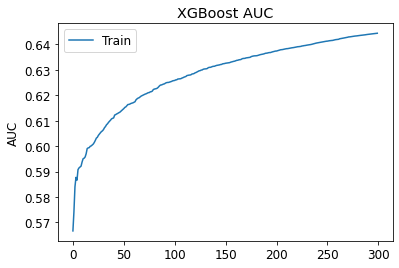

In [ ]:
from matplotlib import pyplot

results = model.evals_result()
print(results)
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.legend()
pyplot.ylabel('AUC')
pyplot.title('XGBoost AUC')
pyplot.show()

In [ ]:
import pickle
pickle.dump(model, open("xgb_encoded.pickle.dat", "wb"))

In [ ]:
"""
Checking whether load and save is working okay
"""
loaded_model = pickle.load(open("xgb_encoded.pickle.dat", "rb"))
y_pred = loaded_model.predict(X_valid)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.74%


# Incremental Training for XGB

Not needed anymore, found another fix, read apendix of technical report

In [ ]:
# import xgboost
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# BATCH_SIZE = 10**4
# def trainXGB():
#   model = None

#   for i in range(np.shape(X)[0]//BATCH_SIZE):
#     print("Iteration: "+str(i))

#     x = X[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
#     y = Y[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

#     x = model_inf(torch.tensor(x, dtype=torch.float)).detach().numpy()
#     y = y

#     seed = 7
#     test_size = 0.08
#     X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=test_size, random_state=seed)

#     eval_set = [(X_valid, y_valid)]
#     model = xgboost.train({
#             'update':'refresh',
#             'process_type': 'update',
#             'refresh_leaf': True,
#             'silent': False,
#             'obj': 'auc',
#         }, dtrain=xgboost.DMatrix(X_train, y_train), xgb_model=model)
#     y_pred = model.predict(xgboost.DMatrix(X_valid))
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_valid, predictions)
#     print("Accuracy: %.2f%%" % (accuracy * 100.0))

#   return model

In [ ]:
# trained_model = trainXGB()